<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [9]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [196]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [197]:
# скачаем данные
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/met-office-weather-month.csv'
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTest.csv'
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTrain.csv'

--2022-04-19 12:43:45--  https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/met-office-weather-month.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124682 (122K) [text/plain]
Saving to: ‘met-office-weather-month.csv.3’

met-office-weather- 100%[===================>] 121.76K  --.-KB/s    in 0.02s   

2022-04-19 12:43:45 (5.89 MB/s) - ‘met-office-weather-month.csv.3’ saved [124682/124682]

--2022-04-19 12:43:45--  https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... co

In [323]:
# считаем файлы
ts1 = pd.read_csv("met-office-weather-month.csv")[:502]
ts2_test = pd.read_csv("DailyDelhiClimateTest.csv")
ts2_train =  pd.read_csv("DailyDelhiClimateTrain.csv")

In [324]:
def create_date(row):
    new_month_value = str(row.month)
    if row.month < 10:
      new_month_value = f'0{row.month}'
    
    date = str(row.year) + '-' + new_month_value

    return pd.to_datetime(date)

ts1['date'] = ts1.apply(create_date, axis=1)
first_column = ts1.pop('date')  
ts1.insert(0, 'date', first_column)
ts1 = ts1[['date', 'rain']]
ts1 = ts1[ts1['rain'].notna()]
ts1.head()

,date,rain
0,1978-09-01,26.7
1,1978-10-01,20.4
2,1978-11-01,56.3
3,1978-12-01,276.7
4,1979-01-01,134.8


In [325]:
ts2_train['date'] = pd.to_datetime(ts2_train['date'])
ts2_test['date'] = pd.to_datetime(ts2_test['date'])

In [326]:
ts1.tail()

,date,rain
497,2020-02-01,176.0
498,2020-03-01,75.8
499,2020-04-01,40.0
500,2020-05-01,28.8
501,2020-06-01,117.0


In [327]:
test_share = len(ts2_test) / (len(ts2_test) + len(ts2_train))

threshold = int(len(ts1) * (1 - test_share))
ts1_train = ts1[:threshold]
ts1_test = ts1[threshold:]

print(len(ts1_train), len(ts1_test))

465 37


In [328]:
ts1_train[600:800]

,date,rain


In [329]:
ts2_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [330]:
ts2_train = ts2_train[['date', 'meantemp']]
ts2_test = ts2_test[['date', 'meantemp']]

print(len(ts2_train), len(ts2_test))

1462 114


## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [188]:
ts1[['price']].plot(figsize=(55, 10));
plt.axvline(threshold, color='magenta')

plt.xticks(ticks = np.arange(len(ts1)), labels = ts1['date'], rotation='vertical', fontsize=12)
plt.legend(['Price', 'Threshold train|test']);

KeyError: ignored

In [52]:
ts2_train.drop(ts2_train[ts2_train.meanpressure > 2000].index, inplace=True)

In [53]:
ts2 = ts2_train.append(ts2_test, ignore_index=True, sort=False)

In [54]:
ts2[ts2['meanpressure'] > 2000]

,date,meanpressure


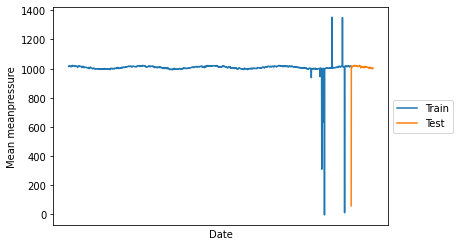

In [55]:
plt.plot(ts2_train['date'], ts2_train[['meanpressure']])
plt.plot(ts2_test['date'], ts2_test[['meanpressure']])
plt.xlabel('Date')
plt.ylabel('Mean meanpressure')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend(['Train', 'Test'], bbox_to_anchor=(1,0.5), loc = 'center left');

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(..., ...)
plt.xlabel('Time')
plt.show()

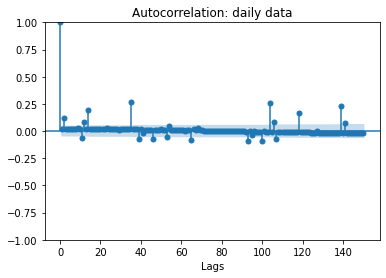

In [60]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(ts2['meanpressure'], lags=150)
plt.xlabel('Lags')
plt.title('Autocorrelation: daily data')
plt.show();

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [206]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts1_train['rain'])

NaiveForecaster()

In [207]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error as MAE

fh = ForecastingHorizon(ts1_test.index, is_relative=False)

ts1_pred1 = forecaster.predict(fh)

In [208]:
MAE(ts1_test['rain'], ts1_pred1)

57.45405405405405

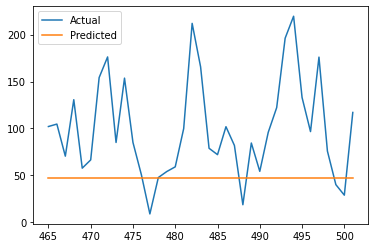

In [209]:
plt.plot(ts1_test['rain'])
plt.plot(ts1_pred1)
plt.legend(['Actual', 'Predicted']);

In [210]:
forecaster = NaiveForecaster(strategy="last", sp = 12)
forecaster.fit(ts1_train['rain'])

NaiveForecaster(sp=12)

In [211]:
ts1_pred = forecaster.predict(fh)

In [212]:
MAE(ts1_test['rain'], ts1_pred)

47.94864864864865

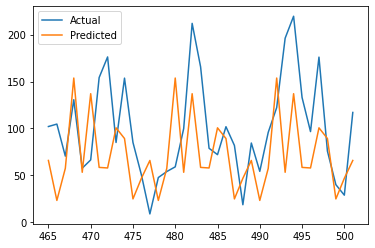

In [213]:
plt.plot(ts1_test['rain'])
plt.plot(ts1_pred)
plt.legend(['Actual', 'Predicted']);

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [214]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

arima = ARIMA(order=(1, 1, 0),
              seasonal_order=(1, 0, 0, 12))
arima.fit(ts1_train['rain'])

ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12))

In [215]:
ts1_pred_a = arima.predict(fh)
MAE(ts1_test['rain'], ts1_pred_a)

62.18719007063791

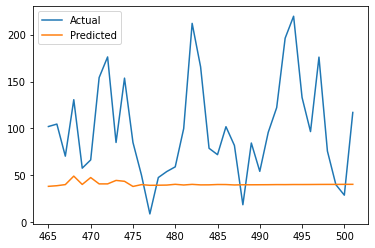

In [216]:
plt.plot(ts1_test['rain'])
plt.plot(ts1_pred_a)
plt.legend(['Actual', 'Predicted']);

In [217]:
ts1_train['rain'].isnull().values.any()

False

In [218]:
aarima = AutoARIMA(sp=12)
aarima.fit(ts1_train['rain'])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


AutoARIMA(sp=12)

In [219]:
ts1_pred_aa = aarima.predict(fh)
MAE(ts1_test['rain'], ts1_pred_aa)

40.48072342100927

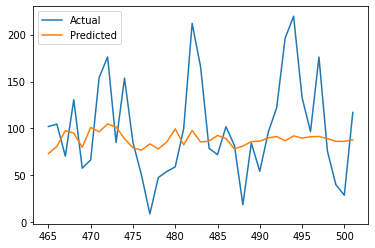

In [220]:
plt.plot(ts1_test['rain'])
plt.plot(ts1_pred_aa)
plt.legend(['Actual', 'Predicted']);

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [221]:
from orbit.models import LGT
from orbit.models import DLT

dlt = DLT(
    response_col='rain', 
    date_col='date',
    seasonality=12,
)


In [222]:
ts1_train.nunique()

date    465
rain    387
dtype: int64

In [223]:
ts33 = ts1_train[500:520]

In [224]:
ts33

,date,rain


In [225]:
dlt.fit(ts1_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [226]:
# ts1_test = ts1_test[100:200]
ts1_test.tail()

,date,rain
497,2020-02-01,176.0
498,2020-03-01,75.8
499,2020-04-01,40.0
500,2020-05-01,28.8
501,2020-06-01,117.0


In [227]:
predicted_df = dlt.predict(ts1_test)
predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2017-06-01,-6.203143,56.983601,122.664402
1,2017-07-01,-1.698586,72.250366,150.435478
2,2017-08-01,18.187355,86.890540,156.359541
3,2017-09-01,2.890980,70.781361,147.302012
4,2017-10-01,25.692966,103.098878,193.612167


In [228]:
predicted_df.tail()

,date,prediction_5,prediction,prediction_95
32,2020-02-01,-5.282996,82.815387,169.320022
33,2020-03-01,-15.851614,63.471012,148.804291
34,2020-04-01,-8.520758,61.604827,157.717292
35,2020-05-01,-25.547575,48.416777,125.421820
36,2020-06-01,-34.201689,55.428198,149.994349


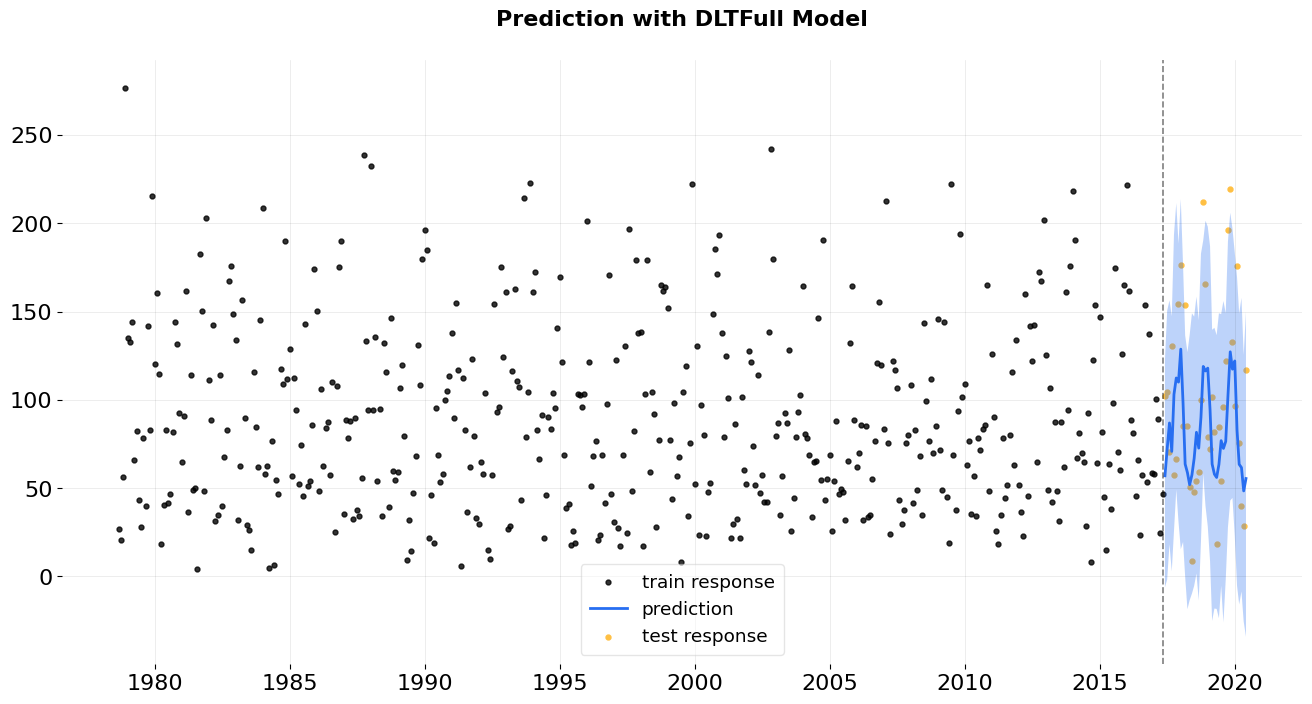

In [229]:
from orbit.diagnostics.plot import plot_predicted_data

plot_predicted_data(
    training_actual_df=ts1_train, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_test,
    title='Prediction with DLTFull Model'
);

In [230]:
MAE(ts1_test['rain'], predicted_df['prediction'])

38.869929316116625

In [231]:
lgt = LGT(
    response_col='rain', 
    date_col='date',
    seasonality=12,
)

In [232]:
lgt.fit(ts1_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [233]:
predicted_df = lgt.predict(ts1_test)

In [234]:
predicted_df.tail()

,date,prediction_5,prediction,prediction_95
32,2020-02-01,17.261133,91.440402,154.944403
33,2020-03-01,-9.764806,68.223849,148.750378
34,2020-04-01,-9.244843,59.455062,136.787511
35,2020-05-01,-22.297451,51.619153,138.559510
36,2020-06-01,-23.644388,55.583444,141.309327


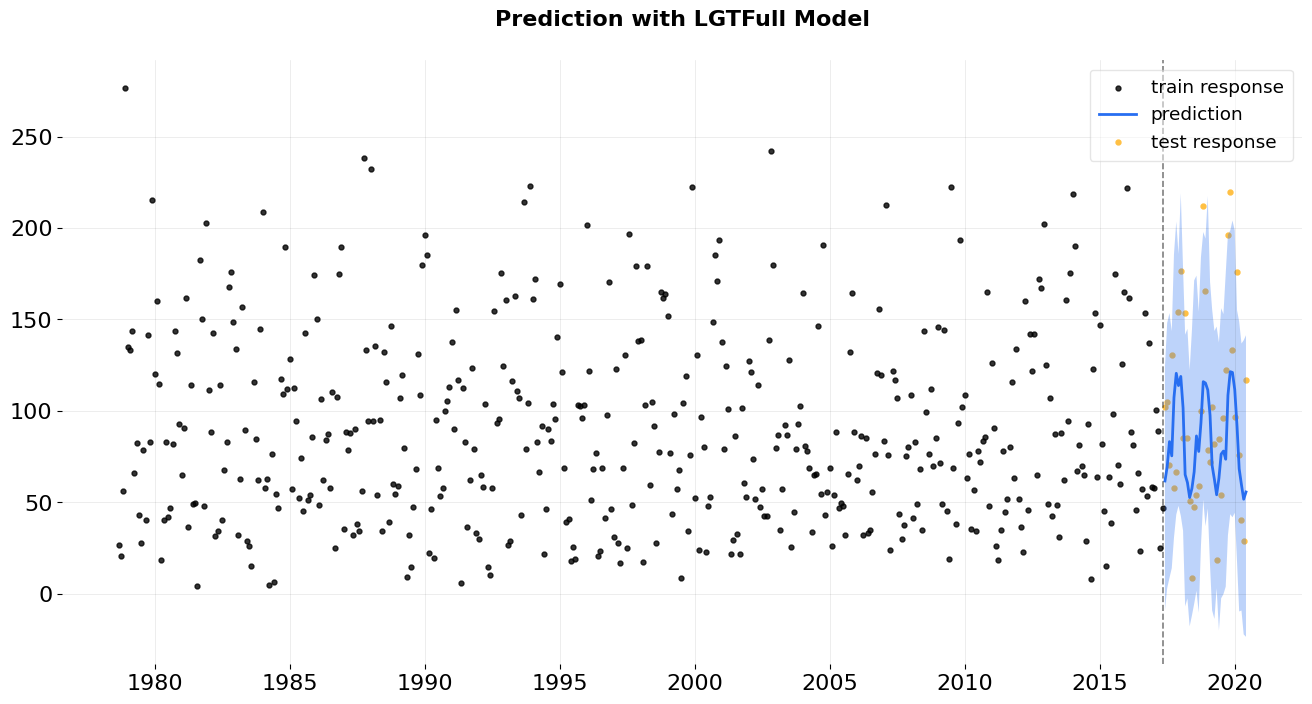

In [235]:
plot_predicted_data(training_actual_df=ts1_train, predicted_df=predicted_df,
                    date_col=lgt.date_col, actual_col=lgt.response_col,
                    test_actual_df=ts1_test, 
                    title='Prediction with LGTFull Model');

In [236]:
MAE(ts1_test['rain'], predicted_df['prediction'])

38.155142823679356

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [237]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [238]:
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster.fit(ts1_train['rain'])

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='add')

In [239]:
predictETS = forecaster.predict(fh)
MAE(ts1_test['rain'], predictETS)

38.75084885327607

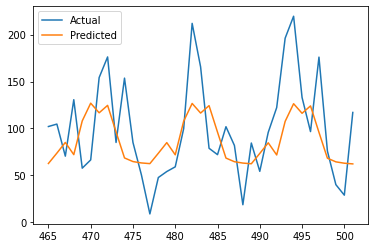

In [240]:
plt.plot(ts1_test['rain'])
plt.plot(predictETS)
plt.legend(['Actual', 'Predicted']);

In [241]:
forecaster = AutoETS(auto=True, sp=12)
forecaster.fit(ts1_train['rain'].astype('float64'))

AutoETS(auto=True, sp=12)

In [242]:
predictAETS = forecaster.predict(fh)

In [243]:
MAE(ts1_test['rain'], predictAETS)

36.75162412349777

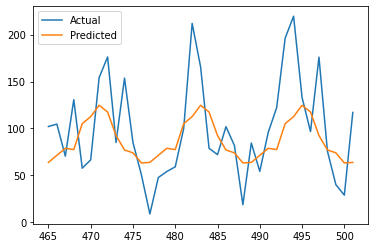

In [244]:
plt.plot(ts1_test['rain'])
plt.plot(predictAETS)
plt.legend(['Actual', 'Predicted']);

In [245]:
ts1_test['Pred'] = predictAETS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [246]:
ts1_test.head()

,date,rain,Pred
465,2017-06-01,102.0,63.744047
466,2017-07-01,104.6,71.277687
467,2017-08-01,70.4,78.776827
468,2017-09-01,130.6,77.411119
469,2017-10-01,57.6,105.037031


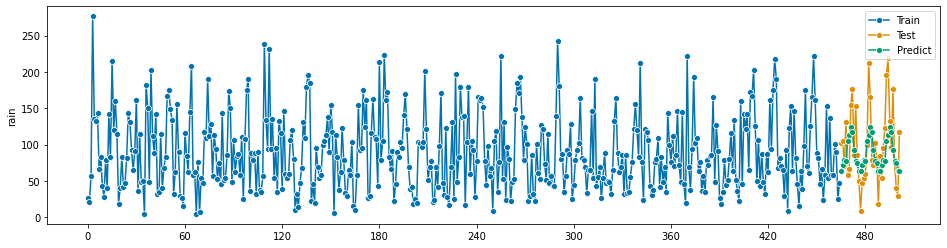

In [247]:
from sktime.utils.plotting import plot_series
plot_series(ts1_train['rain'], ts1_test['rain'], ts1_test['Pred'],
            labels=["Train", "Test", "Predict"],
            #pred_int = True
            );

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [331]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts2_train['meantemp'])

NaiveForecaster()

In [332]:
ts2_test = ts2_test.set_index([np.arange(1461,1575)])

In [333]:
fh = np.arange(len(ts2_test['meantemp']))

In [334]:
ts2_pred = forecaster.predict(fh)
MAE(ts2_test['meantemp'], ts2_pred)

11.668757590588353

In [335]:
ts2_test['prednaive1'] = ts2_pred

In [336]:
ts2_test.head()

,date,meantemp,prednaive1
1461,2017-01-01,15.913043,15.052632
1462,2017-01-02,18.500000,10.000000
1463,2017-01-03,17.111111,10.000000
1464,2017-01-04,18.700000,10.000000
1465,2017-01-05,18.388889,10.000000


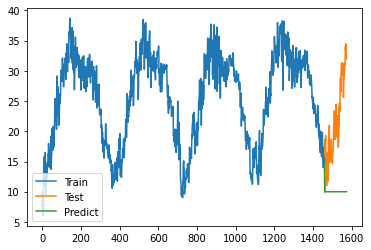

In [337]:
plt.plot(ts2_train['meantemp'])
plt.plot(ts2_test['meantemp'])
plt.plot(ts2_test['prednaive1'])
plt.legend(['Train', 'Test', 'Predict']);

In [338]:
forecaster = NaiveForecaster(strategy="last", sp=365)
forecaster.fit(ts2_train['meantemp'])

NaiveForecaster(sp=365)

In [339]:
ts2_pred2 = forecaster.predict(fh)
MAE(ts2_test['meantemp'], ts2_pred2)

2.61496478142647

In [340]:
ts2_test['prednaive2'] = ts2_pred2

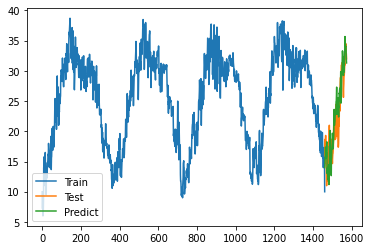

In [341]:
plt.plot(ts2_train['meantemp'])
plt.plot(ts2_test['meantemp'])
plt.plot(ts2_test['prednaive2'])
plt.legend(['Train', 'Test', 'Predict']);

In [342]:
# посчитайте метрики на test

### KTR из orbit (1 балл).



In [343]:
from orbit.models.ktrlite import KTRLite

# ваш код обучения моделей здесь

In [344]:
ktr = KTRLite(
    response_col='meantemp', 
    date_col='date',
    seasonality=365,
)

In [345]:
ktr.fit(ts2_train)

In [346]:
pred_ktr = ktr.predict(ts2_test)
pred_ktr.head()

,date,prediction
0,2017-01-01,15.076624
1,2017-01-02,15.017164
2,2017-01-03,14.964086
3,2017-01-04,14.917450
4,2017-01-05,14.877314


In [347]:
MAE(ts2_test['meantemp'], pred_ktr['prediction'])

2.049350088524792

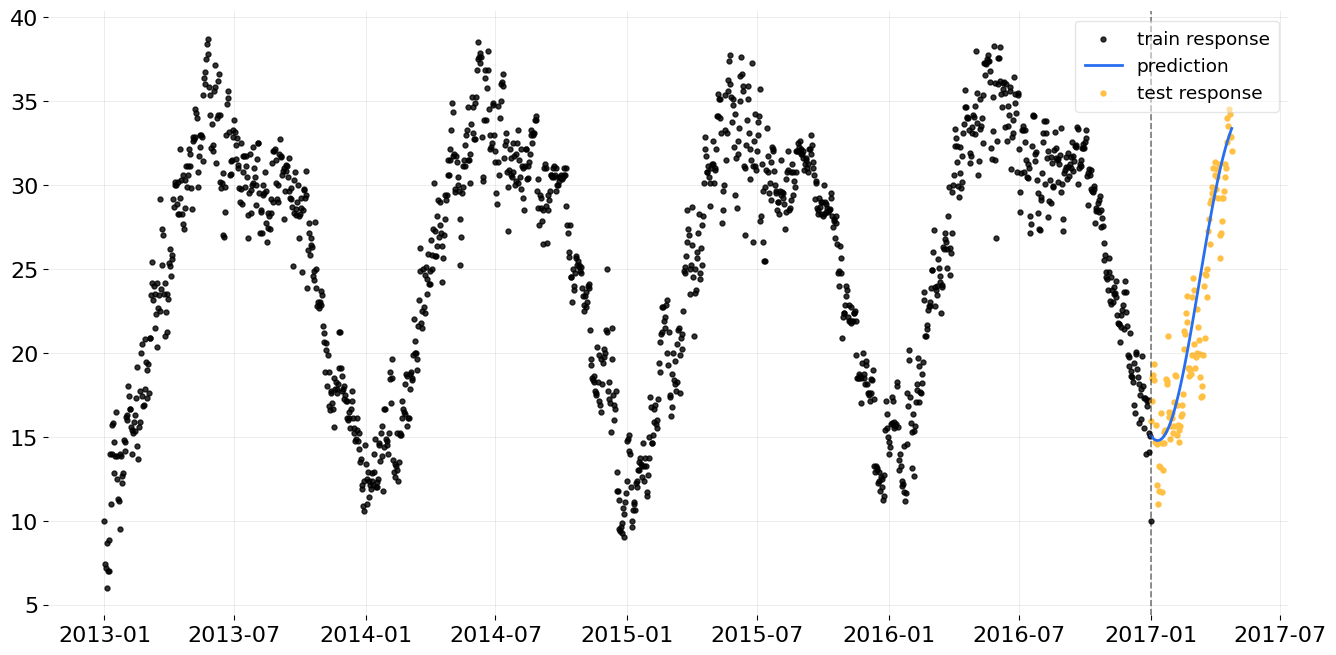

In [348]:
plot_predicted_data(training_actual_df=ts2_train, predicted_df=pred_ktr,
                        date_col=ktr.date_col, actual_col=ktr.response_col,
                        test_actual_df=ts2_test);

In [349]:
# посчитайте метрики на test

### Phophet (1 балл).



In [350]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

In [ ]:
# обучите классические модели ML

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [ ]:
# ваш код модели на STAN и её обучения здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте предсказания